# GraphSAGE 

**DeepWalk** is a transductive algorithm, meaning that, it needs the whole graph to be available to learn the embedding of a node. Thus, when a new node is added to existing ones, it needs to be rerun to generate an embedding for the newcomer.

**GraphSAGE** is an unsupervised node embedding algorithm, known for its success on <u>large graphs</u>. It can utilize <u>node features and node relations</u> to learn vectors for each node that represent the neighborhood structures in the graph. GraphSAGE, a representation learning technique suitable for dynamic graphs. GraphSAGE is capable of predicting embedding of a new node, without requiring a re-training procedure. To do so, GraphSAGE learns <u>aggregator</u> functions that can induce the embedding of a new node given its features and neighborhood. This is called <u>inductive learning</u>.

GraphSAGE algorithms can be devided into three main parts as context construction, information aggregation, and loss function.

**Context Construction:**
GraphSAGE also has a context-based similarity assumption, assumming that nodes that reside in the same neighborhood should have similar embeddings. The definition of the context is parametric. The algorithm has a parameter K that controls the neighborhood depth. If K is 1, only the adjacent nodes are accepted as similar. If K is 2, the nodes at distance 2 are seen in the same neighborhood as well.

![graphsage1.png](attachment:graphsage1.png)

**Information Aggregation:**
<u>GraphSAGE owes its inductivity to its aggregator functions.</u> Having defined the neighborhood, now we need an information sharing procedure between neighbors. Aggregation functions or aggregators accept a neighborhood as input and combine each neighbor’s embedding with weights to create a neighborhood embedding. In other words, they aggregate information from the node’s neighborhood. Aggregator weights are either learned or fixed depending on the function.

Simple aggregator is desired since aggregators affect training time drastically. <u>An ideal aggregator should be simple, learnable and symmetric.</u> In other words, it should learn how to aggregate neighbor embeddings and be indifferent to neighbor order, while not creating a huge training overhead.

To learn embeddings with aggregators, we first initialize embeddings of all nodes to node features. In turn, for each neighborhood depth until K, we create a neighborhood embedding with the aggregator function for each node and concatenate it with the existing embedding of the node. We pass the concatenated vector through a neural network layer to update the node embedding. When each node is processed, we normalize the embeddings to have unit norm. The pseudo-code can be found below.

![graphsage2.png](attachment:graphsage2.png)

The advantage of learning aggregator functions to generate node embeddings, instead of learning the embeddings themselves, is inductivity. When the aggregator weights are learned, the embedding of an unseen node can be generated from its features and neighborhood. As a result, aggregators remove the necessity of re-training when new nodes are introduced to the graph.

We can define various aggregators that are either parametric or nonparametric. As a non-parametric function, we can use <u>simple averaging</u>. A parametric function could be an <u>LSTM cell</u>, which are designed for sequential operations and have memories. Hence, the order that the neighbors are fed to LSTM affects the neighborhood embedding, though there is not an apparent order. To alleviate this, random permutations of the nodes can be fed to LSTM. The parameters of LSTM would be learned when minimizing the loss function. Another learnable aggregator is a single layer neural network followed by a <u>max-pooling operator</u>. To do so, we pass each neighbor’s embedding from a non-linear layer and apply an element-wise max operation to their outcomes. In the paper, this function is shown as the most promising one based on the experiments.

**Loss Function:**
To learn the weights of aggregators and the embeddings, we need a differentiable loss function. Based on our intuition, we want neighboring nodes to have similar embeddings and independent nodes to have distant embedding vectors. The function below satisfies these two conditions with two terms.

![graphsage3.png](attachment:graphsage3.png)

Here u and v are two neighbors and the loss computed for u. The first term promotes maximizing the similarity of embeddings of u and v as we desired. In the second term, we have a variable Q, which is is the number of negative samples and vₙ is a negative sample drawn from negative sample distribution. A negative sample in this context means a non-neighbor node. This term tries to set apart embeddings of these two nodes. Lastly, σ is used to denote the sigmoid function as usual.

Remark that this is an unsupervised loss function that can be minimized with no labels. To use GraphSAGE in a supervised context, we have two options. We can either learn node embeddings as the first step and then learn the mapping between embeddings and labels, or we can add a supervised loss term to loss function and adopt an end-to-end learning procedure. This flexibility is valuable.

## Implementation

This notebook is a short demo of how **Stellargraph Unsupervised GraphSAGE** can be used to learn embeddings of the nodes representing papers in the CORA citation network. Furthermore, this notebook demonstrates the use of the learnt embeddings in a downstream node classification task (classifying papers by subject). Note that the node embeddings can also be used in other graph machine learning tasks, such as link prediction, community detection, etc.

In the Unsupervised GraphSAGE model, node embeddings are learned by solving a simple classification task: given a large set of "positive" (target, context) node pairs generated from random walks performed on the graph, and an equally large set of "negative" node pairs that are randomly selected from the graph according to a certain distribution, learn a binary classifier that predicts whether arbitrary node pairs are likely to co-occur in a random walk performed on the graph. Through learning this simple binary node-pair-classification task, the model automatically learns an inductive mapping from attributes of nodes and their neighbors to node embeddings in a high-dimensional vector space, which preserves structural and feature similarities of the nodes. Unlike embeddings obtained by algorithms such as Node2Vec, this mapping is inductive: given a new node with attributes and its links to other nodes in the graph, which was unseen during model training, we can evaluate its embeddings without having to re-train the model.

**CORA** is a dataset of academic papers of seven different classes. It contains the citation relations between the papers as well as a binary vector for each paper that specifies if a word occurs in the paper. Thus, CORA contains both content-based features for each paper and relationship features between the papers. We can model these features with a network where each paper is represented by a node that carries the content-based features and citations are represented with edges.

![CoraBalloons.png](attachment:CoraBalloons.png)

To implement GraphSAGE, we use a Python library **stellargraph** which contains off-the-shelf implementations of several popular geometric deep learning approaches, including GraphSAGE.

*Objective: Given a graph, learn embeddings of the nodes using only the graph structure and the node features, without using any known node class labels (hence "unsupervised"; for semi-supervised learning of node embeddings).*

#### Graph Creation

In [2]:
!pip install stellargraph

     |████████████████████████████████| 440kB 2.7MB/s 


In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))

G, nodeData = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


#### Model Training

In [8]:
nodes = list(G.nodes())
numWalks = 1
length = 5
batchSize = 50
epochs = 4
numSamples = [10,5]

In [10]:
unsupervisedSamples = UnsupervisedSampler(G, nodes=nodes, length=length, number_of_walks=numWalks)
generator = GraphSAGELinkGenerator(G, batchSize, numSamples)
trainGen = generator.flow(unsupervisedSamples)

In [11]:
layerSizes = [50,50]
graphsage = GraphSAGE(layer_sizes=layerSizes, generator=generator, bias=True, dropout=0.0, normalize='l2')

xIn, xOut = graphsage.in_out_tensors()

prediction = link_classification(output_dim=1, output_act='sigmoid', edge_embedding_method='ip')(xOut)

xOut

link_classification: using 'ip' method to combine node embeddings into edge embeddings


[<tf.Tensor 'lambda/l2_normalize:0' shape=(None, 50) dtype=float32>,
 <tf.Tensor 'lambda/l2_normalize_1:0' shape=(None, 50) dtype=float32>]

In [12]:
model = keras.Model(inputs=xIn, outputs=prediction)

model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), 
              loss=keras.losses.binary_crossentropy, 
              metrics=[keras.metrics.binary_accuracy],)

history = model.fit(trainGen, epochs=epochs, verbose=1, use_multiprocessing=False, workers=4, shuffle=True,)

Epoch 1/4
434/434 [==============================] - 66s 151ms/step - loss: 0.5658 - binary_accuracy: 0.7427
Epoch 2/4
434/434 [==============================] - 66s 152ms/step - loss: 0.5414 - binary_accuracy: 0.7678
Epoch 3/4
434/434 [==============================] - 66s 153ms/step - loss: 0.5376 - binary_accuracy: 0.7730
Epoch 4/4
434/434 [==============================] - 66s 152ms/step - loss: 0.5357 - binary_accuracy: 0.7771


In [13]:
xInSrc = xIn[0::2]
xOutSrc = xOut[0]

embeddingModel = keras.Model(inputs=xInSrc, outputs=xOutSrc)

nodeIds = nodeData.index
nodeGen = GraphSAGENodeGenerator(G, batchSize, numSamples).flow(nodeIds)

nodeEmbeddings = embeddingModel.predict(nodeGen, workers=4, verbose=1)

55/55 [==============================] - 2s 43ms/step


#### Vizualize the node embeddings

In [22]:
print("Total EMbeddings:", nodeEmbeddings.shape[0], "of length:", nodeEmbeddings.shape[1])


print("\n\n\n***********Embedding for the node 0***********")
nodeEmbeddings[0]

Total EMbeddings: 2708 of length: 50



***********Embedding for the node 0***********


array([ 0.06556168,  0.10559807, -0.08453515, -0.05182989,  0.05820891,
        0.07419088,  0.20307687,  0.14149225, -0.08534174, -0.01158983,
        0.08723808, -0.02221779, -0.1244837 ,  0.03667748, -0.07123353,
       -0.03991304, -0.06437209,  0.04635144, -0.09514304,  0.01542589,
       -0.08226129,  0.02993154, -0.04488873, -0.00745219,  0.10804602,
       -0.20801261,  0.02080843, -0.18245178,  0.14290465,  0.33504   ,
       -0.14657469,  0.2391748 ,  0.01390641, -0.3557617 , -0.22464924,
        0.2272407 ,  0.16999058, -0.14659058, -0.39940807,  0.08829214,
        0.1508794 ,  0.00541682, -0.09807033, -0.13075256, -0.03031688,
        0.1187806 , -0.14560106, -0.00132644, -0.04844987, -0.07439201],
      dtype=float32)

In [ ]:
nodeDatas = nodeData.astype("category").cat.codes

X = nodeEmbeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    embTransformed = pd.DataFrame(trans.fit_transform(X), index=nodeIds)
    embTransformed["label"] = nodeDatas
else:
    embTransformed = pd.DataFrame(X, index=nodeIds)
    embTransformed = embTransformed.rename(columns={"0": 0, "1": 1})
    embTransformed["label"] = nodeDatas

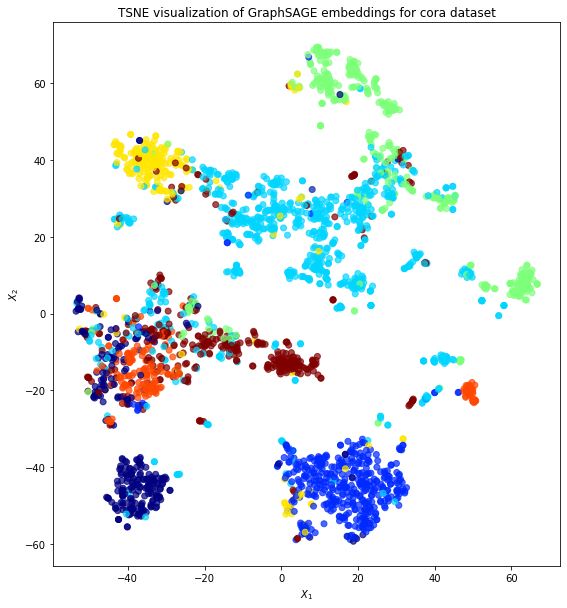

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(
    embTransformed[0],
    embTransformed[1],
    c=embTransformed["label"].astype("category"),
    cmap="jet",
    alpha=0.7,
)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")

plt.title("{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__))

plt.show()

## References

- Hamilton, Will, Zhitao Ying, and Jure Leskovec. “Inductive representation learning on large graphs.” Advances in Neural Information Processing Systems. 2017.

- https://relational.fit.cvut.cz/dataset/CORA

- https://towardsdatascience.com/using-graphsage-to-learn-paper-embeddings-in-cora-a94bb1e9dc9d

- https://towardsdatascience.com/an-intuitive-explanation-of-graphsage-6df9437ee64f

- https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/graphsage-unsupervised-sampler-embeddings.ipynb#scrollTo=6xOLvfxq-jFV